In [6]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%matplotlib inline ensures that the plot is displayed directly below the code cell in the notebook interface, allowing you to view the plot without needing to open a separate window.

In [7]:
class Value:
        
    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other, label='constant')
        out = Value(self.data + other.data, (self, other), '+')

        def backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other, label='constant')
        out = Value(self.data * other.data, (self, other), '*')

        def backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = backward

        return out
    
    def tanh(self):
        t = math.tanh(self.data)
        out = Value(t, (self, ), 'tanh')

        def backward():
            self.grad += (1.0 - t ** 2) * out.grad
        out._backward = backward

        return out
    
    def exp(self):
        t = math.exp(self.data)
        out = Value(t, (self, ), 'exp')

        def backward():
            self.grad += t * out.grad
        out._backward = backward

        return out
    
    def backprop(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1
        for node in reversed(topo):
            node._backward()
        

In [8]:
from graphviz import Digraph

def trace(root):
    #builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label="{ %s| data %.4f| grad %.4f}" % (n.label, n.data, n.grad), shape='record')

        if n._op:
            dot.node(name = uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #edge was added as (child, v)
        #connect n1 to operation node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

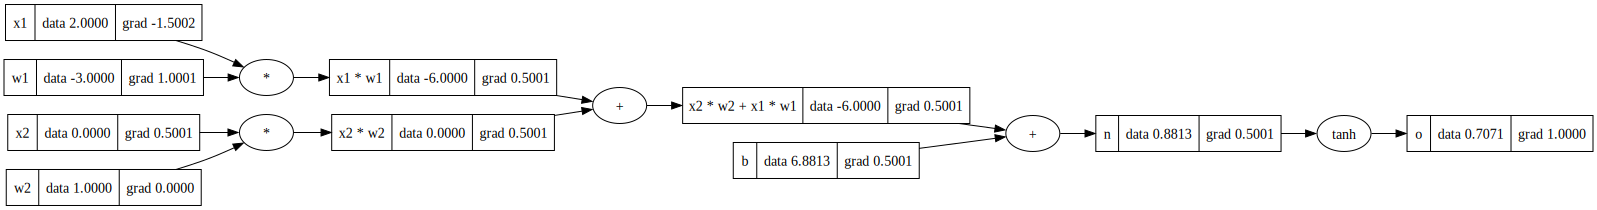

In [9]:
#designing an actual possible neural network

#input
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weight
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#sum
x1w1 = x1 * w1; x1w1.label = 'x1 * w1'
x2w2 = x2 * w2; x2w2.label = 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x2 * w2 + x1 * w1'
n = x1w1x2w2 + Value(6.8813, label='b'); n.label = 'n'
o = n.tanh(); o.label='o' 

o.backprop()
draw_dot(o)


In [22]:
# designing an equation

# k = exp(a + b) * 2 * (f + g) + (a + j)*2

a = Value(2, label='a')
b = Value(0.2, label='b')
c = a + b; c.label = 'c'
d = c.exp(); d.label = 'd'
e = d * 2; e.label = 'e'
f = Value(0.3, label='f')
g = Value(0.1, label='g')
h = f + g; h.label = 'h'
i = h * e; i.label = 'i'
j = Value(1.3, label='j')
m = j + a; m.label = 'm'
k = m * 2; k.label = 'k'
l = k + i; l.label = 'l'

draw_dot(l)
l.backprop()
draw_dot(l)

def check():
    delta = 0.0001

    a = Value(2, label='a')
    b = Value(0.2, label='b')
    c = a + b; c.label = 'c'
    d = c.exp(); d.label = 'd'
    e = d * 2; e.label = 'e'
    f = Value(0.3, label='f')
    g = Value(0.1, label='g')
    h = f + g; h.label = 'h'
    i = h * e; i.label = 'i'
    j = Value(1.3, label='j')
    m = j + a; m.label = 'm'
    k = m * 2; k.label = 'k'
    l = k + i; l.label = 'l' 
    L1 = l.data

    a = Value(2 + delta, label='a')
    b = Value(0.2, label='b')
    c = a + b; c.label = 'c'
    d = c.exp(); d.label = 'd'
    e = d * 2; e.label = 'e'
    f = Value(0.3, label='f')
    g = Value(0.1, label='g')
    h = f + g; h.label = 'h'
    i = h * e; i.label = 'i'
    j = Value(1.3, label='j')
    m = j + a; m.label = 'm'
    k = m * 2; k.label = 'k'
    l = k + i; l.label = 'l' 
    L2 = l.data

    print((L2 - L1)/delta)

check()

9.220371812155292
